# Detecção de sinais modulados por PSK por um canal Rayleigh através de Machine Learning

## Objetivos:
1) Encontrar os parâmetros necessários para que o algoritmo se aproxima o máximo possível da probabilidade de erro mínima possível teoricamente.

2) Descrever e classificar os hiperparâmetros dos algoritmos de classificação.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

np.random.seed(4)

### Variáveis

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy' or 'rayleigh'
M            = 8      # PSK modulation
total_num_symbols  = 30000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(Mod, M, SNR_dB, channel_type)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 18.89420973183859 % for SNR = 15 dB


### Generate PSK symbols and transmit them over the channel

In [4]:
# Converter radianos em graus
def degreeConvert(c, round=False):
    r = np.real(c)
    i = np.imag(c)

    if round:
        z = np.round(np.rad2deg(np.arctan(i/r)))
    else:
        z = np.rad2deg(np.arctan(i/r))
    if (r < 0).all():
        return z + 180*(i/np.abs(i))
    else:
        return z

In [39]:
#Cálculo do erro teórico PSK
amostras = 10000000
t_symb, class_symb, channel_symb = Model(Mod, amostras, M, channel_type, Es, code_rate, SNR_dB)
    
ind_neg = np.argwhere(np.real(channel_symb)<0)[:,0]
ind_pos = np.argwhere(np.real(channel_symb)>=0)[:,0]

neg_symb = degreeConvert(channel_symb[ind_neg])
pos_symb = degreeConvert(channel_symb[ind_pos])

degree_output = np.concatenate((neg_symb, pos_symb), axis=None)

class_org = np.concatenate((class_symb[ind_neg], class_symb[ind_pos]), axis=None)

symb_org = np.concatenate((t_symb[ind_neg], t_symb[ind_pos]), axis=None)

rate = 0
for ii in range(M):
    selected_indices = np.argwhere(class_org==ii)
    selected_indices = selected_indices.reshape((-1))
    deg_otm = degreeConvert(symb_org[selected_indices[0]], True)
    for i in selected_indices:
        if degree_output[i] > deg_otm - 180/M and degree_output[i] < deg_otm + 180/M:
            rate += 1

print(f"O erro teórico calculado fazendo uso das regiões de ótima decisão foi de: {100 - (rate/amostras)*100}%")

(0j, (1+0j))
O erro teórico calculado fazendo uso das regiões de ótima decisão foi de: 14.89806999999999%


In [5]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [6]:
v, indices2, channel_output2 = Model(Mod, total_num_symbols, M, 'awgn', Es, code_rate, SNR_dB)

In [7]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

#scaler = StandardScaler()
#scaler.fit(X_train)  # Don't cheat - fit only on training data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [8]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train2 = indices2[:train_size]
X_train2 = np.stack([np.real(channel_output2[:train_size]),
                    np.imag(channel_output2[:train_size])], axis=1)

# Test
y_test2 = indices2[train_size:]
X_test2 = np.stack([np.real(channel_output2[train_size:]),
                   np.imag(channel_output2[train_size:])], axis=1)

#scaler = StandardScaler()
#scaler.fit(X_train)  # Don't cheat - fit only on training data
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

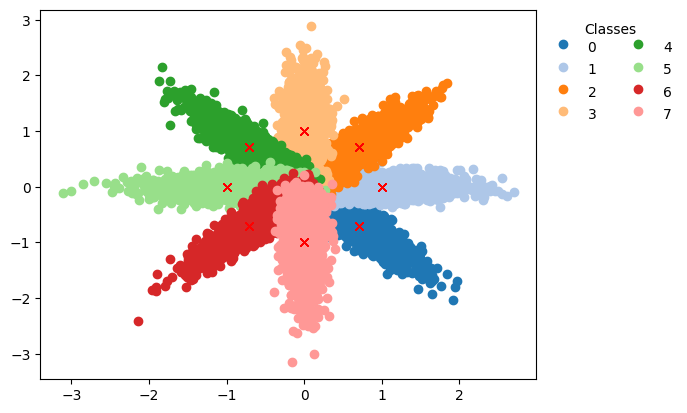

In [9]:
plot_symbols(X_train, y_train, M, symbs)

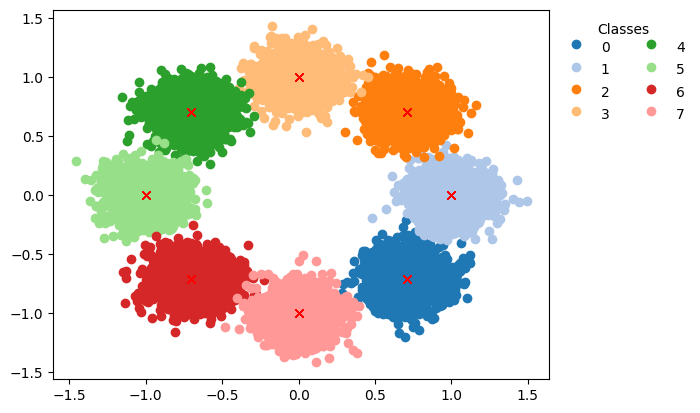

In [10]:
plot_symbols(X_train2, y_train2, M, symbs)

## KNN (Classificação dos vizinhos mais próximos)

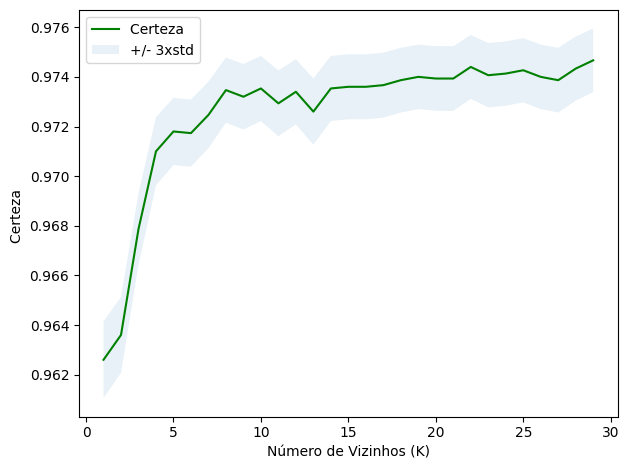

A melhor aproximação foi  0.9746666666666667 com k= 29
Utilizando o pesos de forma uniform foi obtido uma pontuação de 0.9746666666666667
Utilizando o pesos de forma distance foi obtido uma pontuação de 0.9738


In [47]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vizinhos (K)')
plt.tight_layout()
plt.show()

print( "A melhor aproximação foi ", mean_acc.max(), "com k=", mean_acc.argmax()+1)

for w in ['uniform','distance']:
    neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1, weights=w).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    print(f'Utilizando o pesos de forma {w} foi obtido uma pontuação de {accuracy_score(y_test, yhat)}') 

## Train the classifier

In [ ]:
nca = NeighborhoodComponentsAnalysis()
knn = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1, weights='uniform', algorithm='auto', 
                                   leaf_size=30, p=2, metric='minkowski', 
                                   metric_params=None, n_jobs=None)

classifier = Pipeline([('nca', nca), ('knn', knn)])

classifier.fit(X_train, y_train)

In [ ]:
classifier_ = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1, weights='uniform', algorithm='auto', 
                                   leaf_size=30, p=2, metric='minkowski', 
                                   metric_params=None, n_jobs=None)

classifier_.fit(X_train, y_train)

### Plot decision regions for training set and confusion matrix for test set

In [ ]:
plot_decision_boundary(classifier_, X_train, y_train, legend=True)
plot_confusion_matrix(classifier_, X_test, y_test, M)

## Calculate the misclassification error

In [ ]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for Rayleigh channel:\t {Pe:.2%}')

### Naive Bayes

Faz uso do teorema de Bayes para determinar P(Y|x)
Para tal descreve P(x|y) como uma gaussiana e adequa seus parâmetros fazendo uso da máxima verossimilhança

## Train the classifier

In [13]:
classifier = GaussianNB()
#classifier = CategoricalNB()
classifier.fit(X_train, y_train) #train the classifier based on the training set

GaussianNB()

### Plot decision regions for training set and confusion matrix for test set

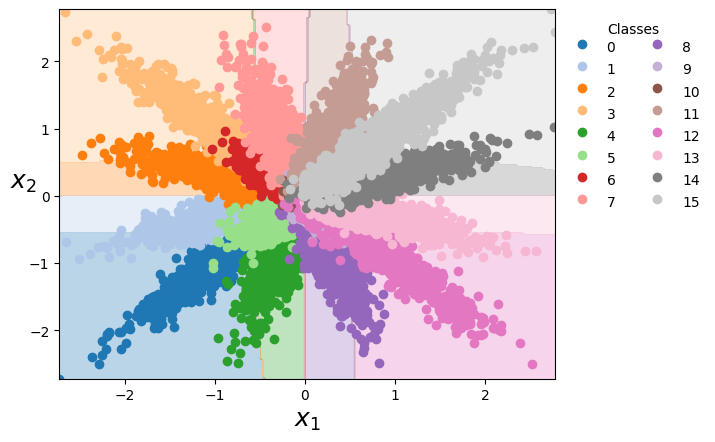

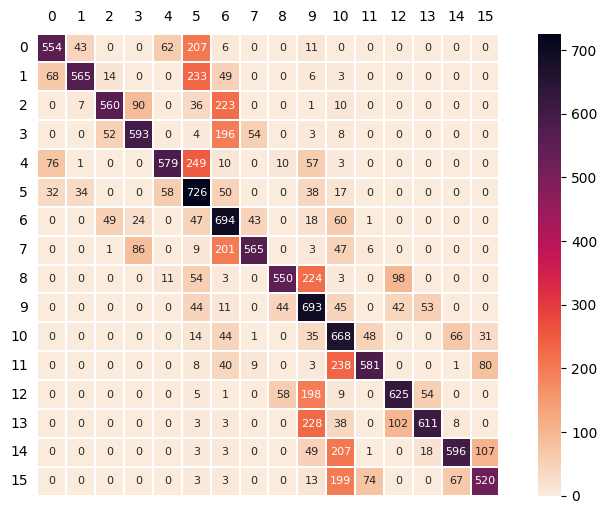

In [14]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [15]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for Rayleigh channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 35.47%
Theoretical SER for Rayleigh channel:	 16.31%


### Support Vector Machine (SVM)

Constroi um hiperplano que divide os conjuntos de dados

### Parâmetros importantes:

#### C -> Ajusta o tamanho da margem entre o hiperplano e os dados (C grande, margem pequena)
#### Gamma -> Ajuste do hiperplano ao conjunto de dados (Gamma grande, ajuste maior)
#### Kernel -> construção do hiperplano a partir da forma dos dados (linear ou curva)

In [36]:
params = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','linear']}
clf = GridSearchCV(estimator=SVC(), param_grid=params, cv=5, n_jobs=5, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 1, 'gamma': 1, 'kernel': 'linear'}


## Train the classifier

In [37]:
classifier = SVC(C=clf.best_params_['C'], kernel=clf.best_params_['kernel'], gamma=clf.best_params_['gamma'], coef0=0.0, shrinking=True, 
                  probability=False, tol=0.001, cache_size=800, class_weight=None, 
                  verbose=False, max_iter=-1, decision_function_shape='ovr', 
                  break_ties=False, random_state=None)

classifier.fit(X_train, y_train)

SVC(C=1, cache_size=800, gamma=1, kernel='linear')

### Plot decision regions for training set and confusion matrix for test set

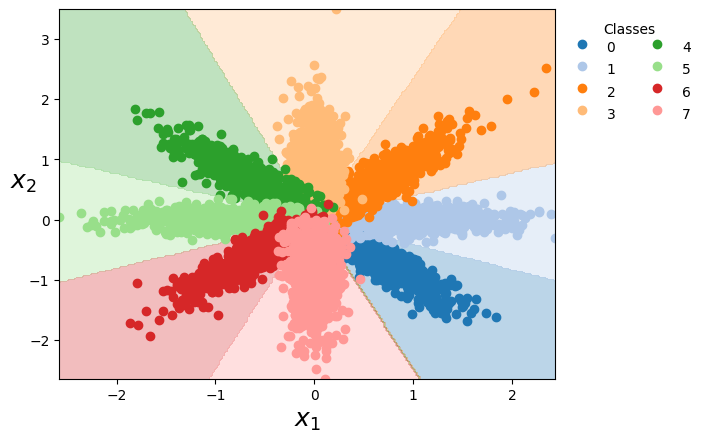

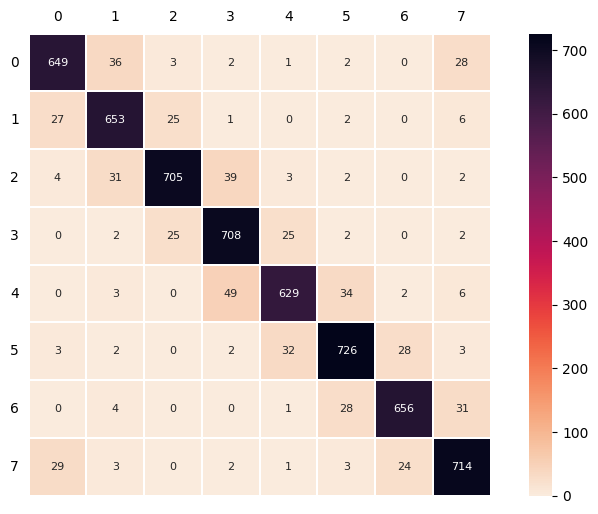

In [38]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [39]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for Rayleigh channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 9.33%
Theoretical SER for AWGN channel:	 0.23%


### Neural Net

## Train the classifier

In [40]:
classifier = MLPClassifier(alpha=0.0001, max_iter=3000, hidden_layer_sizes=(100,), 
                            activation='logistic', solver='sgd', batch_size='auto', 
                            learning_rate='constant', learning_rate_init=0.001,  
                            shuffle=True, random_state=None, tol=0.0001,
                            early_stopping=False, validation_fraction=0.1, n_iter_no_change=10)

classifier.fit(X_train, y_train) #train the classifier based on the training set

MLPClassifier(activation='logistic', max_iter=3000, solver='sgd')

### Plot decision regions for training set and confusion matrix for test set

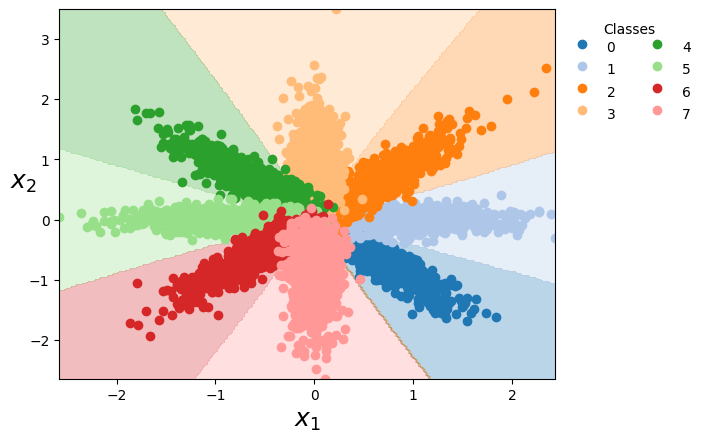

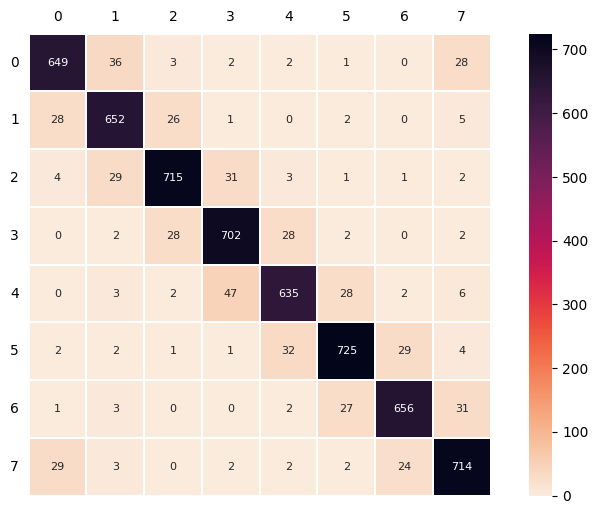

In [41]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

## Calculate the misclassification error

In [42]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for Rayleigh channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 9.20%
Theoretical SER for AWGN channel:	 0.23%
